# HESS + MAGIC combined analysis

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore
from regions import CircleSkyRegion
import gammapy.background as background
from gammapy.image import SkyImage
from gammapy.spectrum.models import LogParabola
from gammapy.utils.energy import EnergyBounds
from gammapy.spectrum import (
    models, SpectrumExtraction, SpectrumObservationList, SpectrumFit, SpectrumResult,
    SpectrumEnergyGroupMaker, FluxPointEstimator,
)
from gammapy.spectrum import CrabSpectrum
import matplotlib.pyplot as plt

In [2]:
# take one run from MAGIC
MAGIC_DIR = '../data/magic'
magic_datastore = DataStore.from_dir(MAGIC_DIR)
magic_obs_ids = [5029747]
#magic_datastore.info()
magic_obs_list = magic_datastore.obs_list(magic_obs_ids)

# take one run from HESS
HESS_DIR = '../data/hess'
hess_datastore = DataStore.from_dir(HESS_DIR)
hess_obs_ids = [23523]
#hess_datastore.info()
hess_obs_list = hess_datastore.obs_list(hess_obs_ids)

# target position (Crab Ra and Dec) and exclusion file for the background estimation
target_position = SkyCoord(ra='83d37m59.0988s', dec='22d00m52.2s')
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'
allsky_mask = SkyImage.read(EXCLUSION_FILE)

In [3]:
def get_SpectrumObservation(obs_list, on_region_radius):
    """function for obtaining a '~gammapy.spectrum.SpectrumObservation' object from a '~gammapy.data.DataStoreObservation'
    N.B. we are considering the case in which the obs_list consists of only one run
    ~gammapy.spectrum.SpectrumObservationList' can be created in this way without defining an obs/hdu-index.tar.gz 
    and feeded directly to the SpectrumFit method.
    
    Parameters:
    -----------
    obs_list : '~gammapy.data.DataStoreObservation'
        run / list of runs 
    on_region_radius : '~astropy.coordinates.Angle'
        size of the on region
    ebounds : '~astropy.units.Quantity'
        energy bins of the on/off counts array 
    
    Returns:
    --------
    '~gammapy.spectrum.SpectrumObservation' containing on/off count vectors and IRFs
    """
    # define the on region
    on_region = CircleSkyRegion(center = target_position, radius = on_region_radius)
    
    

    exclusion_mask = allsky_mask.cutout(position = on_region.center,
                                        size = Angle('6 deg'),
                                       )
    
    # background estimator (reflected regions)
    background_estimator = background.ReflectedRegionsBackgroundEstimator(obs_list = obs_list,
                                                                          on_region = on_region,
                                                                          exclusion_mask = exclusion_mask
                                                                          )

    background_estimator.run()
    
    # extract the on/off vectors
    extraction = SpectrumExtraction(obs_list = obs_list,
                                    bkg_estimate = background_estimator.result,
                                    containment_correction=False
                                    )

    extraction.run()

    # returns the SpectrumObservation
    # N.B. we are considering the case in which the obs_list consists of only one run
    return extraction.observations[0] 

/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/matplotlib/colors.py:1241: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/matplotlib/colors.py:1202: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


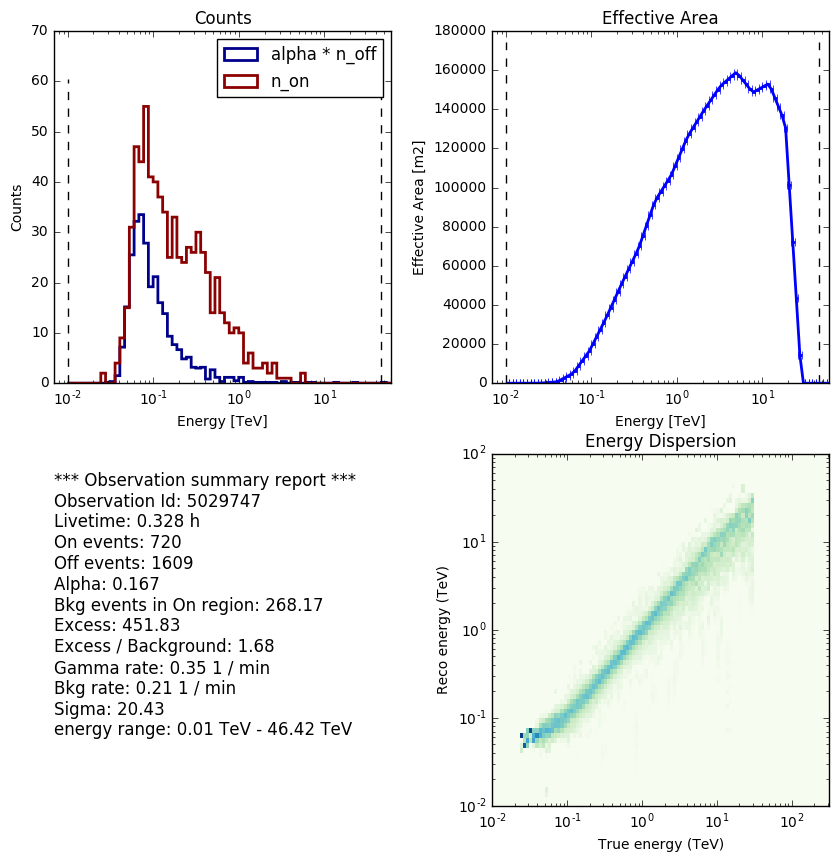

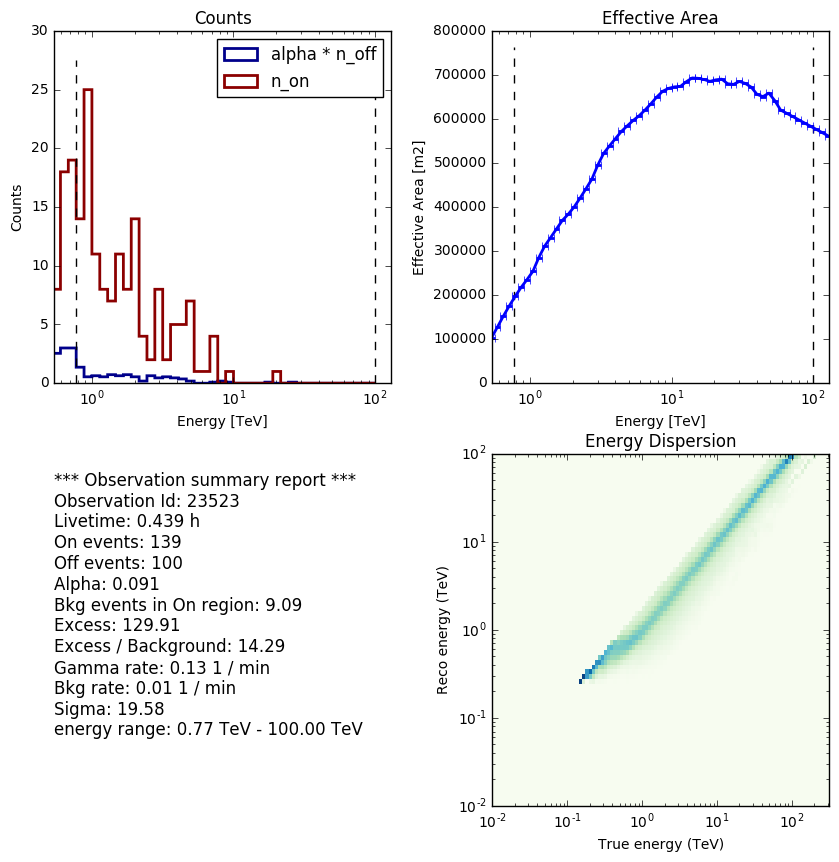

In [4]:
# N.B. MAGIC IRFs are generated with a theta2 cut of 0.02 -> we use an ON region size sqrt(0.02)
# HESS on region size is taken form their analysis notebook
magic_spec_obs = get_SpectrumObservation(magic_obs_list, Angle('0.141 deg')) 
hess_spec_obs = get_SpectrumObservation(hess_obs_list, Angle('0.11 deg')) 

# a small check
magic_spec_obs.peek()
hess_spec_obs.peek()

final_obs_list = SpectrumObservationList([magic_spec_obs, hess_spec_obs])

In [5]:
# we try to fit it with a log parabola
model = LogParabola(amplitude = 3.80*1e-11 * u.Unit('cm-2 s-1 TeV-1'),
                    reference = 1 * u.Unit('TeV'),
                    alpha = 2.47 * u.Unit(''),
                    beta = 0.24 * u.Unit(''))

fit = SpectrumFit(obs_list = final_obs_list, model = model)

fit.fit()
fit.est_errors()

fit_result = fit.result
print(fit.result[0])

/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: LogParabola

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	amplitude 3.596e-11 2.326e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True
	    alpha 2.613e+00 5.841e-02                 nan nan  False
	     beta 1.455e-01 3.402e-02                 nan nan  False

Covariance: 

	name/name amplitude   alpha     beta  
	--------- --------- --------- --------
	amplitude  5.41e-24 -3.36e-17 3.96e-14
	    alpha -3.36e-17   0.00341  0.00132
	     beta  3.96e-14   0.00132  0.00116 

Statistic: 50.360 (wstat)
Fit Range: [  1.00000000e-02   4.64158883e+01] TeV



In [6]:
# Flux points are computed on stacked observation
stacked_obs = final_obs_list.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(0.1, 30, 7, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs = stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds = ebounds)

fpe = FluxPointEstimator(
    obs = stacked_obs,
    groups = seg.groups,
    model = fit.result[0].model,
)
fpe.compute_points()

*** Observation summary report ***
Observation Id: [5029747-23523]
Livetime: 0.767 h
On events: 859
Off events: 1709
Alpha: 0.162
Bkg events in On region: 277.26
Excess: 581.74
Excess / Background: 2.10
Gamma rate: 0.18 1 / min
Bkg rate: 0.08 1 / min
Sigma: 24.97
energy range: 0.01 TeV - 100.00 TeV


/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/afs/ifh.de/group/amanda/scratch/cosimo/miniconda2/lib/python2.7/site-packages/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


(array([-0.15562684,  0.22300615, -0.00641204, -0.1560497 ,  0.19967825,
        0.16040968, -1.625924  ]), array([ 0.10531944,  0.11238113,  0.08914716,  0.10670168,  0.22067747,
        0.44722461,  0.83848412]))


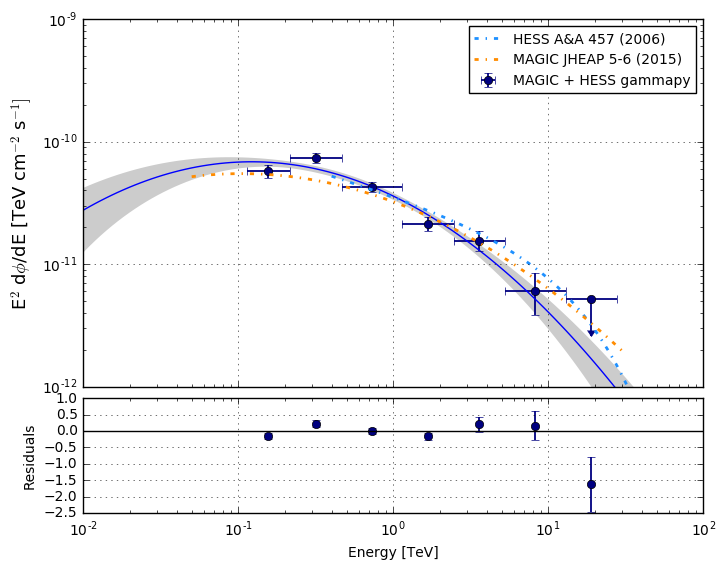

In [7]:
fig = plt.figure()
crab_hess_ecpl = CrabSpectrum('hess_ecpl')
crab_magic_lp = CrabSpectrum('magic_lp')

spectrum_result = SpectrumResult(
    points=fpe.flux_points,
    model=fit_result[0].model,
)

print (spectrum_result.flux_point_residuals)

ax0, ax1 = spectrum_result.plot(
    energy_range=fit.result[0].fit_range,
    energy_power=2, flux_unit='TeV-1 cm-2 s-1',
    fig_kwargs=dict(figsize = (8,8)),
    point_kwargs=dict(color='navy', marker='o', linewidth = 1.3, capsize = 3., label = 'MAGIC + HESS gammapy')
)

# plot HESS and MAGIC reference spectrum
crab_hess_ecpl.model.plot([0.4,50] * u.TeV, ax=ax0, energy_power=2, flux_unit='TeV-1 cm-2 s-1',
                         ls ='-.', lw=2, color='dodgerblue', label = 'HESS A&A 457 (2006)')

crab_magic_lp.model.plot([0.05,30] * u.TeV, ax=ax0, energy_power=2, flux_unit='TeV-1 cm-2 s-1',
                         ls ='-.', lw=2, color='darkorange', label = 'MAGIC JHEAP 5-6 (2015)')



ax0.yaxis.grid(True, linewidth = 0.4) 
ax0.xaxis.grid(True, linewidth = 0.4)

ax1.yaxis.grid(True, linewidth = 0.4) 
ax1.xaxis.grid(True, linewidth = 0.4)


ax0.legend(loc = 0, numpoints = 1, prop={'size':10})
ax0.set_ylabel(r'E$^2$ d$\phi$/dE [TeV cm$^{-2}$ s$^{-1}]$', size=13.)
ax0.set_xlim(0.01, 100)
ax0.set_ylim(1e-12, 1e-9)
fig.savefig('DL3_HESS+MAGIC.png')